In [2]:
import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506032030_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506032030_0


In [3]:
class MultiBasisDataLoader:
    char2id = {'Z': 0, 'X': 1, 'Y': 2}

    def __init__(self,
                 data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):

        lengths = [v.shape[0] for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have equal length, got: {lengths}")

        self._bases = list(data_dict.keys())
        self._arrays = list(data_dict.values())

        self.n_visible = data_dict[self._bases[0]].shape[1]
        self.total_samples = lengths[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self._encoded_bases = []
        for basis_str in self._bases:
            if len(basis_str) != self.n_visible:
                raise ValueError(f"All basis strings must have length {self.n_visible}. "
                                 f"Got '{basis_str}' length {len(basis_str)}.")
            enc = np.array([MultiBasisDataLoader.char2id[c] for c in basis_str],
                           dtype=np.int8)
            self._encoded_bases.append(enc)
        # Now self._encoded_bases is a list of np.int8 arrays, each shape (n_visible,)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.total_samples, batch_size)
            if not drop_last or (i + batch_size <= self.total_samples)
        ]

    def __iter__(self):
        self._order = np.arange(self.total_samples)
        if self.shuffle:
            self.rng.shuffle(self._order)
        self._slice_idx = 0
        return self

    def __next__(self) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if self._slice_idx >= len(self.idx_slices):
            raise StopIteration

        s, e = self.idx_slices[self._slice_idx]
        self._slice_idx += 1

        batch_arrays = []
        for arr in self._arrays:
            # arr has shape (total_samples, n_visible)
            sub = arr[self._order[s:e], :]
            batch_arrays.append(sub)   # (batch_size, n_visible)

        data_array = jnp.stack(batch_arrays, axis=0)

        # basis_ids_array: shape (N_B, n_visible), dtype=int8
        basis_ids_array = jnp.stack(self._encoded_bases, axis=0) # (N_B, n_visible)

        return basis_ids_array, data_array  # ready for model.apply

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [4]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [5]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        basis_array, data_array = data_tuple  # (N_B, n_visible), (N_B, B, n_visible)
        loss_sums = jax.vmap(self._rotated_log_prob_loss)(data_array, basis_array)

        per_basis_mean = loss_sums / data_array.shape[1]
        return jnp.sum(per_basis_mean)

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), -1)

    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)

    def _rotated_log_prob_loss(self, data: jnp.ndarray, basis_ids: jnp.ndarray) -> jnp.ndarray:

        B, n = data.shape
        non_z = jnp.nonzero(basis_ids != 0, size=2, fill_value=-1)[0]
        j, k = non_z[0], non_z[1]
        b1, b2 = basis_ids[j], basis_ids[k]

        SQRT2 = jnp.sqrt(2.0)
        rot_X = jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2
        rot_Y = jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / SQRT2

        Rj = jax.lax.switch(b1 - 1, [lambda: rot_X, lambda: rot_Y])
        Rk = jax.lax.switch(b2 - 1, [lambda: rot_X, lambda: rot_Y])
        U = jnp.kron(Rj, Rk)  # (4, 4)

        combos = jnp.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]], dtype=data.dtype)  # (4, 2)

        sigma_b_tiled = jnp.tile(data[:, None, :], (1, 4, 1))  # (B, 4, n)
        sigma_mod = sigma_b_tiled.at[:, :, [j, k]].set(combos[None, :, :])  # (B, 4, n)
        sigma_flat = sigma_mod.reshape(B * 4, n)  # (4B, n)

        F_amp = self._free_energy_amp(sigma_flat).reshape(B, 4)
        F_pha = self._free_energy_pha(sigma_flat).reshape(B, 4)

        # log-sum-exp trick: log|sum_i(exp(z_i))| = z_max_real + log|sum_i(exp(z_i - z_max_real))|
        log_mag = -0.5 * F_amp
        angle   = -0.5 * F_pha
        M = jnp.max(log_mag, axis=1, keepdims=True)
        scaled = jnp.exp(log_mag - M + 1j * angle)  # (B, 4)

        idx_in = (data[:, j].astype(int) << 1) | data[:, k].astype(int)  # shift first bit left then combine: 00 -> 1, ... , 11 -> 4
        U_cols = U[:, idx_in]  # (4, B)   # getting column for each measurement pair (creating a batch of columns)

        S_prime = jnp.sum(U_cols.T * scaled, axis=1)
        log_probs = 2.0 * (M.squeeze() + jnp.log(jnp.abs(S_prime) + 1e-12))  # (B,)

        return -jnp.sum(log_probs)

In [6]:
@jax.jit
def train_step_pha(state: TrainState, amp_vars: Dict[str, jnp.ndarray], data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: state.apply_fn({'params': params, 'amp': amp_vars}, data_tuple)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:                       # (basis_ids, data_array)
            state, loss = train_step_pha(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [7]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [14]:
batch_size    = 6400
visible_units = 10
hidden_units  = 10
num_epochs    = 600
init_lr       = 1e-3
weight_decay  = 0.5

key   = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_basis  = jnp.zeros((1, visible_units), dtype=jnp.int8)
dummy_data   = jnp.zeros((1, batch_size, visible_units), dtype=jnp.float32)
vars_pha = model_pha.init(key, (dummy_basis, dummy_data))

optim = optax.adamw(init_lr, weight_decay=weight_decay)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha  = MultiBasisDataLoader(dict_pha, batch_size=batch_size, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

Epoch 1/600 │ Loss: -76.7579
Epoch 2/600 │ Loss: -76.8302
Epoch 3/600 │ Loss: -76.9159
Epoch 4/600 │ Loss: -77.0095
Epoch 5/600 │ Loss: -77.1080
Epoch 6/600 │ Loss: -77.2096
Epoch 7/600 │ Loss: -77.3129
Epoch 8/600 │ Loss: -77.4171
Epoch 9/600 │ Loss: -77.5217
Epoch 10/600 │ Loss: -77.6258
Epoch 11/600 │ Loss: -77.7293
Epoch 12/600 │ Loss: -77.8318
Epoch 13/600 │ Loss: -77.9329
Epoch 14/600 │ Loss: -78.0325
Epoch 15/600 │ Loss: -78.1303
Epoch 16/600 │ Loss: -78.2264
Epoch 17/600 │ Loss: -78.3205
Epoch 18/600 │ Loss: -78.4126
Epoch 19/600 │ Loss: -78.5027
Epoch 20/600 │ Loss: -78.5907
Epoch 21/600 │ Loss: -78.6766
Epoch 22/600 │ Loss: -78.7604
Epoch 23/600 │ Loss: -78.8422
Epoch 24/600 │ Loss: -78.9219
Epoch 25/600 │ Loss: -78.9996
Epoch 26/600 │ Loss: -79.0752
Epoch 27/600 │ Loss: -79.1490
Epoch 28/600 │ Loss: -79.2209
Epoch 29/600 │ Loss: -79.2909
Epoch 30/600 │ Loss: -79.3590
Epoch 31/600 │ Loss: -79.4255
Epoch 32/600 │ Loss: -79.4902
Epoch 33/600 │ Loss: -79.5534
Epoch 34/600 │ Loss

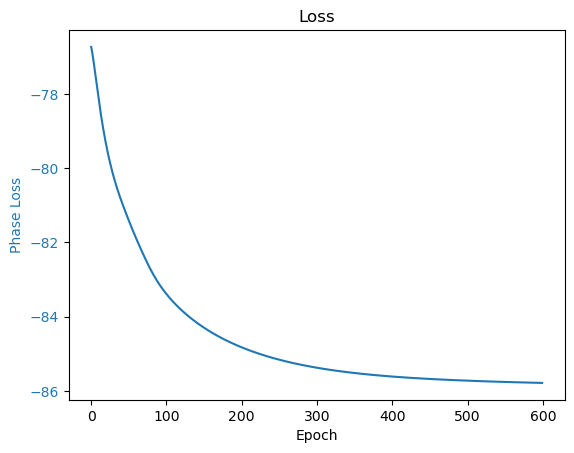

In [9]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [10]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)  # one-hot states for visible units

variables_pha_trained = { "params": state_pha.params, "amp": amp_vars }
phases_model_raw = model_pha.apply(variables_pha_trained, one_hot_states, method=model_pha.compute_phase)

phases_model_wrapped = phases_model_raw % (2 * jnp.pi)

phases_model_tuple = list(zip(one_hot_states, phases_model_raw, phases_model_wrapped))

for state, phase_raw, phase_wrapped in phases_model_tuple:
    bitstring = ''.join('1' if s > 0 else '0' for s in state)
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: 12.6448 (raw), 0.0784 (wrapped)
0100000000: 16.9361 (raw), 4.3697 (wrapped)
0010000000: 14.6071 (raw), 2.0407 (wrapped)
0001000000: 12.4551 (raw), 6.1719 (wrapped)
0000100000: 16.7557 (raw), 4.1893 (wrapped)
0000010000: 14.9323 (raw), 2.3659 (wrapped)
0000001000: 12.5053 (raw), 6.2221 (wrapped)
0000000100: 15.2718 (raw), 2.7054 (wrapped)
0000000010: 13.0547 (raw), 0.4883 (wrapped)
0000000001: 15.6985 (raw), 3.1321 (wrapped)


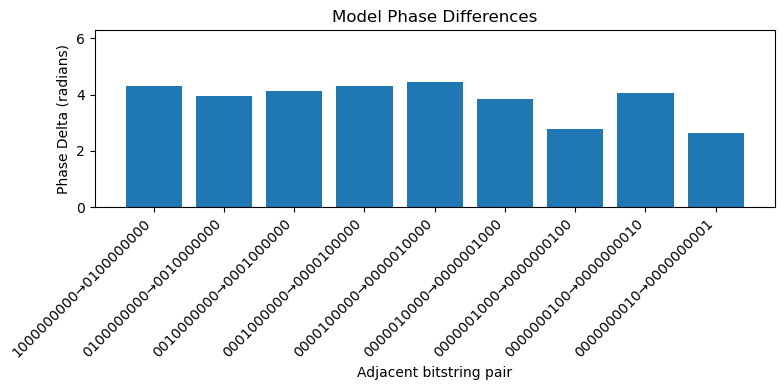

In [11]:
bitstrings = [''.join('1' if val > 0.5 else '0' for val in row) for row in one_hot_states]
phases_np = np.array(phases_model_wrapped)

#fig, ax = plt.subplots(figsize=(8, 4))
#ax.bar(bitstrings, phases_np)
#ax.set_xlabel("One-hot bitstring")
#ax.set_ylabel("Phase (radians, in [0, 2 pi])")
#ax.set_title("Wrapped Phases φₖ ∈ [0, 2π] for One-hot States")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

delta = (phases_np[1:] - phases_np[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]}→{bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Model Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()

In [12]:
def load_state_vector_txt(file_path: Path) -> dict:
    state_dict = {}
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            bitstring, rest = line.strip().split(": ")
            complex_str = rest.split(" + ")[0]
            state_dict[bitstring] = complex(complex_str)
    return state_dict


data_dir = Path("data")
file_path_txt = data_dir / "w_aug_state.txt"
state_vector_dict = load_state_vector_txt(file_path_txt)

# use bitstrings to access all one-hot states
reference_amplitudes = [state_vector_dict[bs] for bs in bitstrings]
reference_phases_raw = np.angle(reference_amplitudes)  # get raw phases in radians
reference_phases_wrapped = reference_phases_raw % (2 * jnp.pi)
bitstring_amplitude_pairs = list(zip(bitstrings, reference_amplitudes, reference_phases_raw, reference_phases_wrapped))

# Display the bitstrings and their corresponding phases
for bitstring, amp, phase_raw, phase_wrapped in bitstring_amplitude_pairs:
    print(f"{bitstring}: ampl: {amp:.4f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

1000000000: ampl: 0.0500-0.3127j (ampl), -1.4122 (raw), 4.8710 (wrapped)
0100000000: ampl: -0.2900+0.1185j (ampl), 2.7537 (raw), 2.7537 (wrapped)
0010000000: ampl: 0.2000-0.2454j (ampl), -0.8870 (raw), 5.3962 (wrapped)
0001000000: ampl: -0.1000-0.2991j (ampl), -1.8935 (raw), 4.3897 (wrapped)
0000100000: ampl: 0.2600+0.1764j (ampl), 0.5961 (raw), 0.5961 (wrapped)
0000010000: ampl: 0.3100-0.0482j (ampl), -0.1544 (raw), 6.1288 (wrapped)
0000001000: ampl: 0.0200-0.3155j (ampl), -1.5075 (raw), 4.7757 (wrapped)
0000000100: ampl: 0.0700-0.3081j (ampl), -1.3474 (raw), 4.9358 (wrapped)
0000000010: ampl: 0.2200+0.2279j (ampl), 0.8031 (raw), 0.8031 (wrapped)
0000000001: ampl: -0.3000+0.0970j (ampl), 2.8289 (raw), 2.8289 (wrapped)


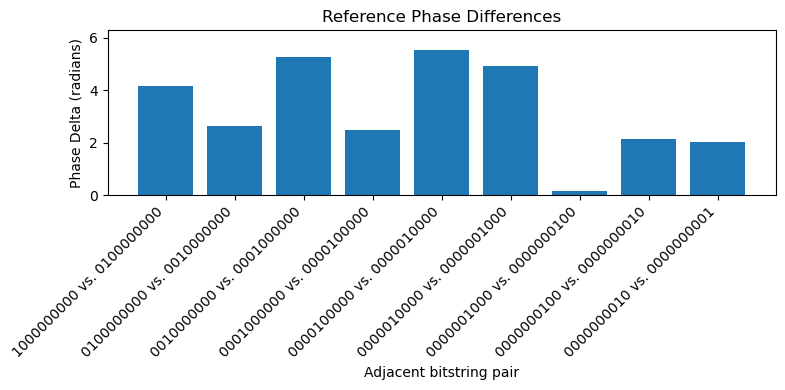

In [13]:
#fig, ax = plt.subplots(figsize=(8, 4))
#ax.bar(bitstrings, reference_phases_wrapped)
#ax.set_xlabel("One-hot bitstring")
#ax.set_ylabel("Phase (radians)")
#ax.set_title("Reference Phases")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

delta = (reference_phases_wrapped[1:] - reference_phases_wrapped[:-1]) % (2*np.pi)
edge_labels = [f"{bitstrings[j]} vs. {bitstrings[j+1]}" for j in range(len(delta))]

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(edge_labels, delta)
ax.set_ylabel("Phase Delta (radians)")
ax.set_xlabel("Adjacent bitstring pair")
ax.set_title("Reference Phase Differences")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 2 * np.pi)
plt.tight_layout()
plt.show()